In [11]:
# !pip install datasets==2.13

In [190]:
# !pip install cm-time
# !pip install tqdm-joblib
# !pip install --upgrade pip
# !pip3 install so-vits-svc-fork
# !pip install wget

In [233]:
import sys
sys.path.insert(1, '../so-vits-svc-fork/src/')
from so_vits_svc_fork.modules.attentions import Encoder

In [330]:
import os
import math
import itertools
import random
from collections import defaultdict
import json
from functools import partial
import pathlib
import re
import unicodedata
from pprint import pprint
import glob
import shutil
from directory_tree import display_tree

from transformers import AutoProcessor, HubertModel
from datasets import load_dataset
import soundfile as sf
import whisperx
import whisper
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import wget

import gc

from sklearn.cluster import MiniBatchKMeans, KMeans
from cm_time import timer
from joblib import Parallel, delayed, cpu_count
from tqdm_joblib import tqdm_joblib
from pathlib import Path
from typing import Any, Tuple, Union, Dict, List
import librosa
from torchaudio.transforms import Resample
from torch.utils.data import Dataset
from torch.nn import Module
from tqdm import tqdm

from pathlib import Path

import IPython.display as ipd

os.environ["http_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["https_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["ftp_proxy"] = "http://proxy.ad.speechpro.com:3128"

In [4]:
# !mkdir RuDevices
# !tar -xf ../NIR/RuDevices.tar -C RuDevices

In [57]:
ds = pathlib.Path("RuDevices")
audios = list(ds.rglob("*.wav"))
len(audios)

93244

### HuBERT

In [4]:
# def map_to_array(batch):
#     speech, _ = sf.read(batch["file"])
#     batch["speech"] = speech
#     return batch

# ds = load_dataset("bond005/sova_rudevices", split="validation", cache_dir='../sambashare/') # TODO split train
# ds = ds.map(map_to_array)

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft").cuda()


In [5]:
# del hubert_model
# torch.cuda.empty_cache()

In [8]:
speech = sf.read(audios[0].resolve())
speech = speech[0]

In [9]:
ipd.Audio(speech, rate=16000)

In [14]:
input_values = processor([speech, speech], sampling_rate=16_000, return_tensors="pt", padding=True).input_values

In [17]:
input_values

tensor([[0.0559, 0.0980, 0.0173,  ..., 0.0232, 0.0219, 0.0217],
        [0.0559, 0.0980, 0.0173,  ..., 0.0232, 0.0219, 0.0217]])

In [18]:
hidden_states = hubert_model(input_values).last_hidden_state

In [19]:
hidden_states.shape, input_values.shape

(torch.Size([2, 164, 1024]), torch.Size([2, 52800]))

In [14]:
torch.cat([hidden_states[0][[1, 3], :], hidden_states[0][[2], :]]).shape, torch.cat([torch.tensor([]), hidden_states[0][[2], :]]).shape

(torch.Size([3, 1024]), torch.Size([1, 1024]))

In [15]:
93680 / 292 / 16000 * 1000 # длина в мс блоков обработки в HuBERT

20.051369863013697

### Whisper

In [16]:
# !pip install git+https://github.com/m-bain/whisperx.git

In [65]:
# model = whisper.load_model("base")
# results = model.transcribe(whisperx.load_audio(audios[0].resolve()), char_timestamps=True)

In [63]:
results

{'text': ' Но тоже 40 рублей не хватает, смысл ли ты ему это?',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 3.02,
   'text': ' Но тоже 40 рублей не хватает, смысл ли ты ему это?',
   'tokens': [50364,
    7264,
    12251,
    3356,
    40851,
    1725,
    32985,
    3310,
    11,
    6871,
    698,
    14393,
    7444,
    5991,
    18220,
    2691,
    30,
    50514],
   'temperature': 0.0,
   'avg_logprob': -0.5190051731310392,
   'compression_ratio': 1.011764705882353,
   'no_speech_prob': 0.0991479679942131,
   'words': [{'word': ' Но',
     'start': 0.0,
     'end': 0.46,
     'probability': 0.19896309077739716},
    {'word': ' тоже',
     'start': 0.46,
     'end': 0.64,
     'probability': 0.7770699262619019},
    {'word': ' 40',
     'start': 0.64,
     'end': 0.86,
     'probability': 0.5905734300613403},
    {'word': ' рублей',
     'start': 0.86,
     'end': 1.1,
     'probability': 0.45090681314468384},
    {'word': ' не',
     'start': 1.1,
     'end'

In [7]:
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)
device = "cuda"
whisper_model = whisperx.load_model("large-v2", device, compute_type=compute_type)

No language specified, language will be first be detected for each audio file (increases inference time).


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.


In [18]:
audio = whisperx.load_audio(audios[0].resolve())
result = whisper_model.transcribe(audio)
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=True)

Detected language: ru (0.94) in first 30s of audio...


In [20]:
whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)["segments"][0]

{'start': 0.41,
 'end': 2.926,
 'text': ' Но то что 40 рублей не хватает, в смысле ты ему это...',
 'words': [{'word': 'Но', 'start': 0.41, 'end': 0.45, 'score': 0.444},
  {'word': 'то', 'start': 0.491, 'end': 0.672, 'score': 0.788},
  {'word': 'что', 'start': 0.732, 'end': 0.933, 'score': 0.7},
  {'word': '40'},
  {'word': 'рублей', 'start': 1.014, 'end': 1.235, 'score': 0.835},
  {'word': 'не', 'start': 1.275, 'end': 1.336, 'score': 0.796},
  {'word': 'хватает,', 'start': 1.376, 'end': 1.859, 'score': 0.987},
  {'word': 'в', 'start': 1.879, 'end': 1.899, 'score': 0.0},
  {'word': 'смысле', 'start': 1.919, 'end': 2.302, 'score': 0.965},
  {'word': 'ты', 'start': 2.342, 'end': 2.463, 'score': 0.863},
  {'word': 'ему', 'start': 2.523, 'end': 2.745, 'score': 0.973},
  {'word': 'это...', 'start': 2.825, 'end': 2.926, 'score': 0.964}]}

### Alignment (without attention mask)

In [47]:
curr_idx = 0
curr_sum = 0

for i in result['segments'][0]['chars']:
    if 'start' in i:
        break
while curr_sum <= i['start']:
    curr_sum += 20 / 1000
    curr_idx += 1
for item in result['segments'][0]['chars']:
    if 'start' in item:
        ids_list = []
        while curr_sum >= item['start'] and curr_sum <= item['end']:
            ids_list.append(curr_idx)
            curr_idx += 1
            curr_sum += 20 / 1000
        print(f"{item['char']}: {item['start']} - {item['end']} - {ids_list}")
#     else:
#         curr_idx += 1
#         curr_sum += 20 / 1000

Н: 0.39 - 0.41 - [20]
о: 0.41 - 0.451 - [21, 22]
 : 0.451 - 0.491 - [23, 24]
т: 0.491 - 0.511 - [25]
о: 0.511 - 0.672 - [26, 27, 28, 29, 30, 31, 32, 33]
 : 0.672 - 0.692 - [34]
ч: 0.692 - 0.732 - [35, 36]
т: 0.732 - 0.873 - [37, 38, 39, 40, 41, 42, 43]
о: 0.873 - 0.954 - [44, 45, 46, 47]
 : 0.954 - 0.974 - [48]
 : 0.974 - 1.014 - [49, 50]
р: 1.014 - 1.034 - [51]
у: 1.034 - 1.115 - [52, 53, 54, 55]
б: 1.115 - 1.155 - [56, 57]
л: 1.155 - 1.175 - [58]
е: 1.175 - 1.236 - [59, 60, 61]
й: 1.236 - 1.256 - [62]
 : 1.256 - 1.276 - [63]
н: 1.276 - 1.316 - [64, 65]
е: 1.316 - 1.336 - [66]
 : 1.336 - 1.397 - [67, 68, 69]
х: 1.397 - 1.437 - [70, 71]
в: 1.437 - 1.477 - [72, 73]
а: 1.477 - 1.558 - [74, 75, 76, 77]
т: 1.558 - 1.598 - [78, 79]
а: 1.598 - 1.779 - [80, 81, 82, 83, 84, 85, 86, 87, 88]
е: 1.779 - 1.839 - [89, 90, 91]
т: 1.839 - 1.859 - [92]
 : 1.859 - 1.88 - [93]
в: 1.88 - 1.9 - [94]
 : 1.9 - 1.92 - [95]
с: 1.92 - 1.98 - [96, 97, 98]
м: 1.98 - 2.02 - [99, 100]
ы: 2.02 - 2.121 - [101, 102, 

## Make-DataSet

In [ ]:
# # Предположим, что 'whisper_alignments' - это список словарей,
# # где каждый словарь содержит 'char' и временные метки 'start' и 'end' для каждого символа
# # И 'hidden_states' - это тензор из HuBERT, где каждый фрейм соответствует 20 мс аудио

# aligned_hidden_states = []

# for alignment in whisper_alignments:
#     start_frame = int(alignment['start'] * 1000 // 20)
#     end_frame = int(alignment['end'] * 1000 // 20)
    
#     # Получаем средний вектор скрытых состояний HuBERT для временного диапазона символа
#     char_hidden_state = hidden_states[start_frame:end_frame].mean(dim=0)
    
#     aligned_hidden_states.append({
#         'char': alignment['char'],
#         'hidden_state': char_hidden_state
#     })

In [30]:
def alignment(result, outputs, hidden_state, audio):
    
    curr_idx = 0
    curr_sum = 0

    for i in result:
        if 'start' in i:
            break
    while curr_sum <= i['start']:
        curr_sum += 20 / 1000
        curr_idx += 1
    for item in result:
        if 'start' in item:
            ids_list = []
            while curr_sum >= item['start'] and curr_sum <= item['end']:
                ids_list.append(curr_idx)
                curr_idx += 1
                curr_sum += 20 / 1000
            if item['char'].lower() not in outputs:
                outputs[item['char'].lower()] = {"contents_ids": [], "audio": [], "count": 0}
            # last = outputs[item['char'].lower()]["contents"]
            # outputs[item['char'].lower()]["contents"] = torch.cat([hidden_state[ids_list, :], last])
            outputs[item['char'].lower()]["contents_ids"].append(ids_list)
            outputs[item['char'].lower()]["audio"].append(audio) # TDOD: set
            outputs[item['char'].lower()]["count"] += 1
    
    return 

In [2]:
# # file | phonems | content
# from IPython.display import clear_output

# ds = pathlib.Path("RuDevices")
# audios = list(ds.rglob("*.wav"))

# global_dict = {}

# for i, audio_path in enumerate(audios):
    
#     audio = whisperx.load_audio(audio_path.resolve())
    
#     # hubert infer
#     input_values = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).input_values
#     hidden_states = hubert_model(input_values).last_hidden_state
    
#     # whisper infer
#     try:
#         result = whisper_model.transcribe(audio)
#         if result["language"] != "ru":
#             continue
#         model_a, metadata = whisperx.load_align_model(language_code="ru", device=device) # result["language"]
#         result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=True)
    
#         if not result['segments']:
#             continue 
        
#         # alighnment
#         alignment(result['segments'][0]['chars'], global_dict, hidden_states[0], audio_path.resolve())
#     except:
#         continue

#     clear_output(wait=False)

In [3]:
# import pandas as pd
# pd.DataFrame(global_dict).to_csv('dataset.csv')

In [4]:
dataset = pd.read_csv('dataset.csv')

In [22]:
dataset

,Unnamed: 0,н,о,,т,ч,р,у,б,л,...,ш,з,ё,щ,ю,г,-,ц,ф,ъ
0,contents_ids,"[[20], [64, 65], [136, 137], [35, 36], [136, 1...","[[21, 22], [26, 27, 28, 29, 30, 31, 32, 33], [...","[[23, 24], [34], [48], [49, 50], [63], [67, 68...","[[25], [37, 38, 39, 40, 41, 42, 43], [78, 79],...","[[35, 36], [64, 65], [159, 160, 161, 162, 163,...","[[51], [18, 19], [61, 62], [87, 88], [110, 111...","[[52, 53, 54, 55], [132, 133, 134, 135, 136, 1...","[[56, 57], [113, 114], [133, 134, 135], [207, ...","[[58], [110, 111], [79, 80], [121, 122, 123, 1...",...,"[[79, 80, 81], [165, 166], [260, 261, 262, 263...","[[132, 133, 134, 135], [301, 302, 303, 304, 30...","[[188, 189, 190, 191, 192, 193, 194, 195, 196,...","[[240, 241], [141], [20], [16], [71, 72], [60,...","[[72, 73, 74, 75, 76, 77], [73, 74, 75, 76], [...","[[156], [223, 224, 225, 226, 227, 228, 229, 23...","[[91], [100], [200, 201], [24], [228], [11, 12...","[[185, 186], [215, 216, 217, 218], [38, 39], [...","[[66, 67], [202, 203], [54, 55, 56, 57], [38, ...","[[214, 215, 216], [91, 92, 93, 94], [204, 205,..."
1,audio,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...,[PosixPath('/mnt/storage/kocharyan/NIR/RuDevic...
2,count,36182,65113,106076,45473,10749,22432,18070,12309,21788,...,4580,8223,2159,1974,4214,7797,2137,1808,1190,197


In [4]:
# ds["н"][]

In [43]:
ds = {}
for col in dataset:
    if col not in ds:
        ds[col] = {}
    ds[col]["contents_ids"] = dataset[col][0]
    ds[col]["audio"] = dataset[col][1]

del ds['Unnamed: 0']

for char in ds:
    ds[char]["audio"] = [*map(lambda x: x.replace("),", "").replace("'", "").strip(), ds[char]["audio"].split("PosixPath(")[1:])]


import re

for char in ds:
    arrays = re.findall(r"\[[\d, ]+\]", ds[char]["contents_ids"]) # Это массивы в виде строк
    content_ids = [[int(number) for number in re.findall(r"\d+", array)] for array in arrays] # Превращение строчных массивов к реальным числовым
    ds[char]["contents_ids"] = content_ids

In [61]:
dataset = pd.read_csv('dataset.csv').to_dict() # правильно обработать !

In [1]:
import sys

In [51]:
class HuBERT_Processor:
    def __init__(self, contents):
        self.contents = contents
        self.processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
        self.hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
        print(self.hubert_model.device)

    def get_content(self, char):
        res = []
        char = self.contents[char]
        audio_list = char["audio"]
        content_ids = char["contents_ids"]
        for audio_path, content in zip(audio_list, content_ids):
            audio = whisperx.load_audio(audio_path) # .resolve()
            input_values = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).input_values
            hidden_states = self.hubert_model(input_values).last_hidden_state[0]
            res.append(hidden_states[content, :])
            print(sys.getsizeof(res) / 1024 / 1024)
        return res



In [52]:
hu_proc = HuBERT_Processor(ds)

cpu


In [4]:
# res = hu_proc.get_content('н')

In [ ]:
for chr in chars:
    for audio_path in audio_path_list:
        yield processor(data[char][audio_path])[data[char][audio_path][content]]

In [62]:
mean_audio_counts = []
mean_freqs = []
for char in ds:
    mean_audio_counts.append(len(set(ds[char]["audio"])))
    mean_freqs.append(len(ds[char]["audio"]))
from statistics import mean
len(ds), mean(mean_audio_counts), mean(mean_freqs)

(35, 8488.314285714287, 19435.314285714285)

In [58]:
len(set(ds["о"]["audio"]))

16668

# Work

In [5]:
# Можно ли инференсить по батчам?
# Clustering https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/cluster/train_cluster.py#L18

In [102]:
class AudioLoad(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform = whisperx.load_audio(self.dataset[idx])
        return waveform

def hubert_processor_collate(batch, processor):
    # wave_forms, _ = zip(*batch) if batch consist of multiple items, e.g. (batch, sr)
    input_values = processor(batch, sampling_rate=16_000, return_tensors="pt", padding=True).input_values
    return input_values

class HuBERTInference(torch.nn.Module):
    
    def __init__(self, hubert):
        super().__init__()
        self.hubert = hubert

    @torch.inference_mode()
    def forward(self, x):
        x = self.hubert(x)
        x = x.last_hidden_state
        return x
        

class WhisperXInference(torch.nn.Module):
    
    def __init__(self, compute_type, device, language):
        super().__init__()
        self.device = device
        self.language = language
        self.whisper = whisperx.load_model("large-v2", self.device, compute_type=compute_type)
        align_model, metadata = whisperx.load_align_model(language_code=self.language, device=self.device)
        self.align_model = align_model
        self.metadata = metadata

    @torch.inference_mode()
    def forward(self, x):
        output = self.whisper.transcribe(x)
        x = whisperx.align(output["segments"], self.align_model, self.metadata, x, self.device, return_char_alignments=True)
        return x

def is_cyrillic(char):
    return 'CYRILLIC' in unicodedata.name(char) #TODO: Add space symb

def align_to_hubert(whisper_output, audio_path, aligns):
    
    for alignment in whisper_output:
        try:
            char = alignment['char'].lower()
            if not is_cyrillic(char):
                raise Exception()
            start = int(alignment['start'] * 1000 // 20)
            end = int(alignment['end'] * 1000 // 20) + 1
            aligns[char][audio_path].append([*range(start, end)])
        except:
            continue
    return 

def defaultdict_to_dict(d):
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_dict(v) for k, v in d.items()}
    return d

def postprocess_whisper_output(output):
    segments = output.get("segments", [])
    if segments:
        if not isinstance(segments[0], dict):
            return []
        return segments[0].get("chars", [])
    return []

def buid_json(aligns, file_name):
    with open(file_name, mode='w+', encoding='utf-8') as file:
        json.dump(defaultdict_to_dict(aligns), file, indent=4, ensure_ascii=False)
        
# processor_ = partial(processor, sampling_rate=16_000, return_tensors="pt", padding=True)
# collate = lambda x:  processor_(list(x)).input_values

In [31]:
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
whisper = WhisperXInference("float16", "cuda", "ru").cuda()

No language specified, language will be first be detected for each audio file (increases inference time).


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.


In [7]:
ds = pathlib.Path("RuDevices")
audio_dataset = list(ds.rglob("*.wav"))
audio_dataset = list(map(lambda x: x.as_posix(), audio_dataset))

In [32]:
%%time 

hubert_audio_dataset = AudioLoad(audio_dataset)
collate = partial(hubert_processor_collate, processor=processor)
hubert_audio_loader = torch.utils.data.DataLoader(hubert_audio_dataset, batch_size=16, collate_fn=collate)

hubert_inf = HuBERTInference(hubert_model).cuda()
hubert_inf.eval()


hubert_inf(next(iter(hubert_audio_loader)).cuda());

NameError: name 'audio_dataset' is not defined

In [73]:
def hubert_infer(file, hubert_inf, processor, device):
    collate = partial(hubert_processor_collate, processor=processor)
    hubert_audio_loader = DataLoader(AudioLoad([file]), batch_size=1, collate_fn=collate)
    hubert_inf.eval()
    hubert_inf = hubert_inf.to(device)
    return hubert_inf(next(iter(hubert_audio_loader)).to(device))

In [34]:
def whisper_infer(file, whisper):
    whisper_audio_loader = DataLoader(AudioLoad([file]), batch_size=1, collate_fn=lambda batch: batch)
    whisper.eval()
    return whisper(next(iter(whisper_audio_loader))[0])

In [9]:
%%time

whisper_ds = AudioLoad(audio_dataset)
whisper_audio_loader = torch.utils.data.DataLoader(whisper_ds, batch_size=1, collate_fn=lambda batch: batch)
whisper.eval()
postprocess_whisper_output(whisper(next(iter(whisper_audio_loader))[0]));

Detected language: ru (0.94) in first 30s of audio...
CPU times: user 731 ms, sys: 164 ms, total: 895 ms
Wall time: 926 ms


In [11]:
aligns = defaultdict(lambda: collections.defaultdict(list))
data = next(iter(whisper_audio_loader))[0]
result = postprocess_whisper_output(whisper(data))
align_to_hubert(result, whisper_ds.dataset[0], aligns)

Detected language: ru (0.94) in first 30s of audio...


In [ ]:
# with open('minimaxDataset.json', mode='w+', encoding='utf-8') as file:
#     json.dump(defaultdict_to_dict(aligns), file, indent=4, ensure_ascii=False)

In [12]:
assert isinstance(pd.read_json("minimaxDataset.json")["Н"][0], list)

In [ ]:
aligns = defaultdict(lambda: defaultdict(list)) # TODO: make with concurrency/multiprocessing
for i, data in enumerate(whisper_audio_loader):
    result = postprocess_whisper_output(whisper(data[0]))
    align_to_hubert(result, whisper_ds.dataset[i], aligns)
buid_json(aligns, 'dataset.json')

In [53]:
len(aligns)

33

In [56]:
assert i == 93243

In [3]:
dataset = pd.read_json('dataset.json')

In [ ]:
# Для каждого символа - количество аудио

In [104]:
sum((~dataset.T.loc['н'].isna()))

68747

In [99]:
stat = {}
for char in dataset:
    stat[char] = sum((~dataset.T.loc[char].isna()))

{'н': 68747,
 'о': 79756,
 'т': 75343,
 'ч': 37410,
 'р': 58271,
 'у': 51153,
 'б': 40407,
 'л': 57460,
 'е': 75440,
 'й': 24079,
 'х': 18969,
 'в': 56275,
 'а': 76112,
 'с': 60886,
 'м': 50194,
 'ы': 33325,
 'э': 14454,
 'ь': 41351,
 'к': 52713,
 'я': 44635,
 'и': 66441,
 'п': 50139,
 'д': 49998,
 'ж': 22252,
 'ш': 18569,
 'з': 30621,
 'ё': 9028,
 'щ': 8620,
 'ю': 16317,
 'г': 28686,
 'ц': 7849,
 'ф': 5005,
 'ъ': 943}

In [121]:
import copy
copy_stat = copy.deepcopy(stat)

for key, value in copy_stat.items():
    copy_stat[key] = [value]

df_ = pd.DataFrame(copy_stat, index=["Audio count"])

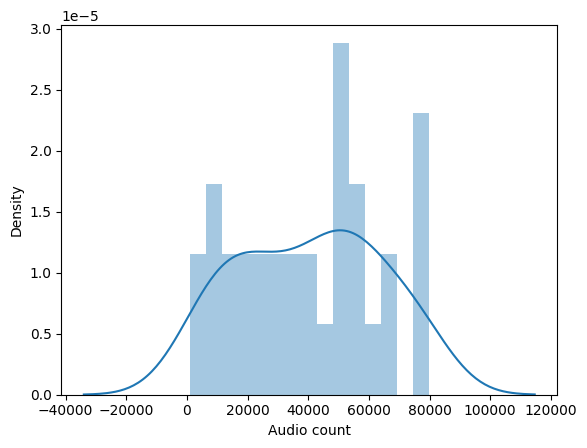

In [134]:
import seaborn as sns
ax = sns.distplot(df_.T, bins=15);
ax.set_xlabel("Audio count");

In [113]:
df_.T.describe()

,0
count,33.000000
mean,40346.909091
std,23415.912840
min,943.000000
25%,18969.000000
50%,41351.000000
75%,57460.000000
max,79756.000000


In [89]:
stat = {}
for char in dataset:
    stat[char] = sum((~dataset.T.loc[char].isna()))

17

In [151]:
np.mean(dataset['н'][~dataset['н'].isna()].map(lambda x: len(x)))

2.526132049398519

In [41]:
def whisper_infer(file, whisper):
    whisper_audio_loader = torch.utils.data.DataLoader(AudioLoad([file]), batch_size=1, collate_fn=lambda batch: batch)
    whisper.eval()
    return whisper(next(iter(whisper_audio_loader))[0])['segments'][0]['text']

In [42]:
with open('RuDevices/0/0/679561f7-3e55-4119-b597-dbb6ab665f98.txt') as f:
    annot = f.read()
print(annot)
_ = {}
for i in annot:
    if i not in _:
        _[i] = 0
    _[i] += 1
del _[" "]

s = {k: len(v) for k, v in dataset.loc['RuDevices/0/0/679561f7-3e55-4119-b597-dbb6ab665f98.wav', :].to_dict().items() if not isinstance(v, float)} 
print(whisper_infer('RuDevices/0/0/679561f7-3e55-4119-b597-dbb6ab665f98.wav', whisper))
for k in _:
    print(_[k], "==", s[k])

ну тоже сорок рублей не хватает смысле ты ему и
Detected language: ru (0.94) in first 30s of audio...
 Но то что 40 рублей не хватает, в смысле ты ему это...
2 == 2
3 == 2
4 == 6
3 == 4


KeyError: 'ж'

In [10]:
ipd.Audio('RuDevices/0/0/679561f7-3e55-4119-b597-dbb6ab665f98.wav', rate=16_000)

In [126]:
len(dataset)

89979

In [44]:
# get hubert content https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/utils.py#L207
# train clusters https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/cluster/train_cluster.py#L18

### Develop

#### Hubert processing / Clustering

In [145]:
!ls ../so-vits-svc-fork/src/so_vits_svc_fork

cluster			  f0.py       inference    __main__.py	  py.typed
dataset.py		  gui.py      __init__.py  modules	  train.py
default_gui_presets.json  hparams.py  logger.py    preprocessing  utils.py


In [2]:
# import sys
# sys.path.insert(1, '../so-vits-svc-fork/src/')
# from so_vits_svc_fork.utils import get_total_gpu_memory
import gc

In [165]:
#TODO: Но это для speaker вектора 
# Надо сделать тоже самое, только для букв (тут для каждого диктора считается кластера)
# https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/cluster/__init__.py

class CharClusters:
    
    def __init__(self, checkpoint_path: Union[str, Path]):
        self.checkpoint_path = Path(checkpoint_path)

    def build_chars_clusters(self):
        with self.checkpoint_path.open("rb") as f:
            checkpoint = torch.load(f, map_location="cpu")
        kmeans = dict()
        for char, ckpt in checkpoint.items():
            _kmns                              = KMeans(ckpt["n_features"])
            _kmns.__dict__["n_features_in_"]   = ckpt["n_features"]
            _kmns.__dict__["_n_threads"]       = ckpt["n_threads"]
            _kmns.__dict__["cluster_centers_"] = ckpt["cluster_centers"].astype(np.float32)
            kmeans[char]                       = _kmns
        self.kmeans = kmeans
        
    def get_cluster_center(self, char: str, item: Any):
        model   = self.kmeans[char]
        predict = model.predict(item)
        return model.cluster_centers_[predict]

    def predict_cluster_center(self, char: str, item: Any):
        model   = self.kmeans[char]
        predict = model.predict(item)
        return predict

def _build_and_fit_minibatch_kmeans(input_path: Path, data_pattern: str, 
                     n_clusters: int, batch_size: int = 4096) -> dict:
    # input_path = Path(input_path)
    feats = list()
    for data_path in input_path.rglob(data_pattern):
        with data_path.open("rb") as file:
            content = (
                torch.load(file, weights_only=True)["content"]
                ).squeeze(0).numpy()# .T # TODO: load form disk
            feats.append(content)
    if not feats:
        raise Exception()
    feats = np.concatenate(feats, axis=0).astype(np.float32)
    print(f"hubert contents shape: {feats.shape}, {feats.nbytes / 1024 / 1024:.2f}")
    with timer() as time:
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, 
                                 n_init="auto", max_iter=100, verbose=False)
        kmeans = kmeans.fit(feats)
    print(f"Clustering time {time.elapsed:.2f} seconds")
    return {
        "n_features": kmeans.n_features_in_,
        "n_threads": kmeans._n_threads,
        "cluster_centers": kmeans.cluster_centers_,
    }

def _kmeans_fitting(input_path: Path, **kwargs: Any) -> Tuple[str, dict]:
    return input_path.stem, _build_and_fit_minibatch_kmeans(input_path, **kwargs)

def cluster_training_on_data(input_path_dir: Union[Path, str], out_path_file: Union[Path, str], 
                             n_clusters: int = 10_000, batch_size: int = 4096, 
                             data_pattern: str = "*.content.pt") -> None:
    input_path_dir = Path(input_path_dir)
    out_path_file  = Path(out_path_file)
    with tqdm_joblib(desc="Training clusters", total=len(list(input_path_dir.iterdir()))): # TODO: tqdm
        resault = Parallel(n_jobs=3)(delayed(_kmeans_fitting)(
            char, data_pattern=data_pattern, 
            n_clusters=n_clusters, batch_size=batch_size
        ) for char in input_path_dir.iterdir())
    out_path_file.parent.mkdir(exist_ok=True, parents=True)
    with out_path_file.open("wb") as f:
        torch.save(dict(resault), f)

In [104]:
HUBERT_SR = 16_000


class HuBERTInference(Module):
    def __init__(self, hubert):
        super().__init__()
        self.hubert = hubert

    @torch.inference_mode()
    def forward(self, x):
        x = self.hubert(x)
        x = x.last_hidden_state
        return x

def hubert_processor_collate(batch, processor):
    # wave_forms, _ = zip(*batch) if batch consist of multiple items, e.g. (batch, sr)
    input_values = processor(batch, sampling_rate=16_000, return_tensors="pt", padding=True).input_values
    return input_values

def hubert_inference(file, hubert_inf, processor, device):
    collate = partial(hubert_processor_collate, processor=processor)
    hubert_audio_loader = DataLoader(AudioLoad([file]), batch_size=1, collate_fn=collate)
    hubert_inf.eval()
    hubert_inf = hubert_inf.to(device)
    return hubert_inf(next(iter(hubert_audio_loader)).to(device))


def get_hubert(model_id: str = "facebook/hubert-large-ls960-ft", device: str = "cuda"):
    processor    = AutoProcessor.from_pretrained(model_id)
    hubert_model = HubertModel.from_pretrained(model_id).to(device)
    hubert_inf   = HuBERTInference(hubert_model).to(device)
    return processor, hubert_model, hubert_inf

def calc_hubert_content(model: Union[HuBERTInference, HubertModel], 
                        audio: Union[torch.Tensor, str, Path], 
                        device: str, sr: int) -> torch.Tensor:
    if isinstance(audio, str) or isinstance(audio, Path):
        contents = model(audio, model, processor, device)
    else:
        # audio, sr = librosa.load(filepath, sr=16_000, mono=True)
        # audio = torch.from_numpy(audio).float().to("cuda")
        # audio = torch.as_tensor(audio)
        if sr != HUBERT_SR:
            audio = Resample(sr, HUBERT_SR).to(audio.device)(audio).to(device)
        if audio.ndim == 1: audio = audio.unsqueeze(0)
        with torch.no_grad():
            contents = model(audio)
            contents = contents.last_hidden_state #.transpose(1, 2) #["last_hidden_state"].transpose(1, 2) #
    return contents


#### Build Whisper ali

In [105]:
# !pip install -U openai-whisper

In [106]:
# # ------------------------------------
# for audio in all_alignments:
#     contents = hubert_infer(audio)
#     for char in all_alignments[audio]:
#         content = contents[ all_alignments[audio][char] ]
#         # save_(char, audio, contents)
#         _content = {"content": content.cpu()} #TODO: CHECK https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/preprocessing/preprocess_hubert_f0.py#L29
#         char_dir = out_dir / Path(char)
#         char_dir.mkdir(parents=True, exist_ok=True) #TODO: CHECK
#         content_path = char_dir / (Path(audio).name + ".content.pt")
#         with content_path.open("wb") as f:
#             torch.save(data, f)
# # -------------------------------------

def _one_item_hubert_infer(file, hubert_model, hps): #TODO
    
    audio, sr = librosa.load(file, sr=hps["data_sr"], mono=True)
    audio     = torch.from_numpy(audio).float().to(hps["device"])
    # https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/preprocessing/preprocess_hubert_f0.py#L65
    content  = calc_hubert_content(hubert_model, audio, hps["device"], sr).to("cpu") #repeat_expand_2d, fixed len
    torch.cuda.empty_cache()
    hps["out_dir"] = Path(hps["out_dir"])

    # print(content.shape) #DEBUG
    
    for char, content_ids in hps["ali"][file].items():
        
        char_dir = hps["out_dir"] / Path(char)
        check_and_create_dir(char_dir)
        
        # content_path = char_dir / (Path(file).name + ".content.pt")
        content_path = char_dir / (".".join(file.split("/")) + ".content.pt")
        with content_path.open("wb") as f:
            hiddens = []
            for content_id in content_ids:
                hiddens.append(content[:, content_id]) # [bs=1, idx=content_id, hidden=1024]
            hiddens = torch.cat(hiddens, 1)
            
            # print(hiddens.shape) #DEBUG
            
            torch.save({"content": hiddens}, f)

def calc_hubert_ali_for_one_char(alignment):
    char = alignment['char'].lower()
    if not (is_cyrillic(char) or char == " "): #TODO: CHECK
        raise Exception()
    start = int(alignment['start'] * 1000 // 20)
    end   = int(alignment['end']   * 1000 // 20) + 1
    return char if char != " " else "bspace", [*range(start, end)]

def get_all_alignments(files_to_whispout: dict) -> dict:
    all_alignments = defaultdict(lambda: defaultdict(list))
    for file, whisper_output in files_to_whispout.items(): #TODO: tqdm
        for alignment in whisper_output:
            try:
                char, content_ids = calc_hubert_ali_for_one_char(alignment)
                all_alignments[file][char].append(content_ids)
            except:
                continue
    return all_alignments

def postprocess_whisper_output(output):
    segments = output.get("segments", [])
    if segments:
        if not isinstance(segments[0], dict):
            return []
        return segments[0].get("chars", [])
    return []

def wip_memory(model):
    del model
    _wip_memory()

def _wip_memory():
    gc.collect()
    torch.cuda.empty_cache()


class WhisperXInference(Module): # переписать 
    
    def __init__(self, compute_type, device, language):
        super().__init__()
        self.device = device
        self.language = language
        self.whisper = whisperx.load_model("large-v2", self.device, compute_type=compute_type)
        align_model, metadata = whisperx.load_align_model(language_code=self.language, device=self.device)
        self.align_model = align_model
        self.metadata = metadata
        self.ali = whisperx.align

    @torch.inference_mode()
    def forward(self, x):
        output = self.whisper.transcribe(x)
        x = self.ali(
            output["segments"], self.align_model, self.metadata, 
            x, self.device, return_char_alignments=True,
        )
        return x


# def _whisper_inf(data, file):
#     whisper = WhisperXInference("float16", device, "ru")
#     return file, postprocess_whisper_output(whisper(data))

def _batch_hubert_infer(files, pbar, hps): #TODO
    proc, hubert_model, _ = get_hubert(model_id="facebook/hubert-large-ls960-ft", device=hps["device"])
    for file in tqdm(files, position=pbar):
        _one_item_hubert_infer(file, hubert_model, hps)
    wip_memory(hubert_model)


def _one_item_whisper_infer(file, whisper):
    res = (
        file, postprocess_whisper_output(
            whisper_inference_for_file(file, whisper)
        )
    )
    torch.cuda.empty_cache()
    return res

def _batch_whisper_infer(files, pbar):
    res = []
    device = "cuda"
    whisper = WhisperXInference("float16", device, "ru")
    for file in tqdm(files, position=pbar):
        res.append(_one_item_whisper_infer(file, whisper))
    wip_memory(whisper)
    return res

# create_hubert_content(data_dir="ridevices_chunk", out_dir=)
def check_and_create_dir(dir: Path):
    dir.mkdir(parents=True, exist_ok=True)

def create_hubert_content(data_dir: Union[str, Path] = "RuDevices", sr: int = 16_000,
                          out_dir: str = "./ali", device: str = "cuda") -> dict:
    # Для каждой аудиозаписи сохраняем словарь из букв и контент-вектров

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True) # TODO: CHECK

    dataset = get_dataset(data_dir)
    # whisper = WhisperXInference("float16", device, "ru")
    # dataset = AudioDataset(dataset)
    # loader  = DataLoader(dataset, batch_size=1, collate_fn=lambda batch: batch)

    audio_files = dataset #TOOD: CHECK | CHECK space symb !!!!!
    n_jobs      = 3 #cpu_count() - 4
    file_chunks = np.array_split(audio_files, n_jobs)
    # files_to_whispout = Parallel(n_jobs=-1)(delayed(_whisper_inf)( # make batch inf ?!
    #     data[0], dataset.dataset[i]
    # ) for i, data in enumerate(loader))
    # files_to_whispout = [_whisper_inf(data[0], dataset.dataset[i]) for i, data in enumerate(loader)]
    
    files_to_whispout = Parallel(n_jobs=n_jobs)(delayed(_batch_whisper_infer)(
        chunk, pbar
    ) for (pbar, chunk) in enumerate(file_chunks))
    # files_to_whispout = [_batch_whisper_infer(chunk, pbar) for (pbar, chunk) in enumerate(file_chunks)]

    files_to_whispout = flatten(files_to_whispout)
    resault = dict(files_to_whispout)

    all_alignments = get_all_alignments(resault)
    with (out_dir / "align.pt").open("wb") as f:
        torch.save({"ali": dict(all_alignments)}, f)
    #TODO: cuda memory clear
    # wip_memory(whisper)
    
    audio_files = list(all_alignments.keys()) #TOOD: CHECK | CHECK space symb !!!!!
    n_jobs      = 3 #cpu_count() - 4
    file_chunks = np.array_split(audio_files, n_jobs)

    # print(file_chunks) # DEGUG

    hps            = {}
    hps["data_sr"] = sr
    hps["out_dir"] = out_dir # "./preprocessed_dataset"
    hps["device"]  = device
    hps["ali"]     = all_alignments
    
    Parallel(n_jobs=n_jobs)(delayed(_batch_hubert_infer)( #TODO
        chunk, pbar, hps
    ) for (pbar, chunk) in enumerate(file_chunks)) #TODO: CHECK (...) for other
    # [_batch_hubert_infer(chunk, pbar, hps) for (pbar, chunk) in enumerate(file_chunks)]
    # add torch.cuda.empty_cache()
    # use hubert for get content
    # Создать папки с именами букв
    # в каждом сохранить для каждого аудио вектора

    return 

In [264]:
class AudioDataset(Dataset):
    
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform = whisperx.load_audio(self.dataset[idx])
        return waveform
        

def whisper_inference_for_file(file, whisper):
    whisper_audio_loader = DataLoader(AudioDataset([file]), batch_size=1, collate_fn=lambda batch: batch)
    whisper.eval()
    return whisper(next(iter(whisper_audio_loader))[0])

def is_cyrillic(char):
    return 'CYRILLIC' in unicodedata.name(char) #TODO: Add space symb

# def align_to_hubert(whisper_output, audio_path, aligns):
#     for alignment in whisper_output:
#         try:
#             char = alignment['char'].lower()
#             if not is_cyrillic(char):
#                 raise Exception()
#             start = int(alignment['start'] * 1000 // 20)
#             end   = int(alignment['end'] * 1000 // 20) + 1
#             aligns[char][audio_path].append([*range(start, end)])
#         except:
#             continue
#     return 

# def defaultdict_to_dict(d):
#     if isinstance(d, defaultdict):
#         d = {k: defaultdict_to_dict(v) for k, v in d.items()}
#     return d

def get_dataset(dataset_dir: Union[Path, str] = "RuDevices", pattern: str = "*.wav"):
    dataset_dir   = Path(dataset_dir)
    audio_dataset = list(dataset_dir.rglob(pattern))
    audio_dataset = list(map(lambda x: x.as_posix(), audio_dataset))
    return audio_dataset

def del_folder(path):
    path = Path(path)
    if not path.exists():
        return
    for sub in path.iterdir():
        if sub.is_dir(): del_folder(sub)
        else : sub.unlink()
    path.rmdir()


def flatten(xss):
    return [x for xs in xss for x in xs]

In [340]:
def calculates_label(
    file: str, ali: Dict[str, List[List]], clusters: CharClusters, 
    hubert_model: HuBERTInference, hubert_preproc: Any
    ):
    
    def get_char(i):
        for ids in idx2char:
            for _id in ids:
                if _id == tuple(i): return idx2char[ids], _id
        return 
    
    idx2char = {tuple(tuple(x) for x in ids): char for char, ids in ali.items()}
    idss     = [get_char(i) for i in sorted(flatten(ali.values()))]
    text     = "".join([i for i, j in idss]).replace("bspace", " ")

    res = []
    hubert_contents = hubert_inference(file, hubert_inf, processor, "cuda") #TODO make unifiy for preprocessing
    src_len = len(hubert_contents[0])
    for char, ids in idss:
        inf_res = hubert_contents[:, ids]
        inf_res = inf_res.cpu().numpy().squeeze(0)
        res.append("".join([*map(lambda x: char+f'({x})',
            clusters.predict_cluster_center(
                char, inf_res.astype(np.float32)
            )
        )]))
    
    return text, "-".join(res), src_len


# Можно взять предобученный TextEncoder из Vits и прикрутить декодер (и обучить это)
# А можно взять (HuBERT + TextEncoder) из SoVits и дистиллировать в TextEncoder (loss навешать между ними)
# и потом прикрутить decoder 
# from transformers import AutoTokenizer, EncoderDecoderModel

# Decoders:
# https://github.com/voicepaw/so-vits-svc-fork/blob/main/src/so_vits_svc_fork/modules/decoders/f0.py#L7
# https://github.com/jaywalnut310/vits/blob/main/attentions.py#L50

# Encoders:
# https://github.com/jaywalnut310/vits/blob/main/attentions.py#L13
# https://github.com/jaywalnut310/vits/blob/main/models.py#L135
# https://github.com/coqui-ai/TTS/blob/dev/TTS/tts/layers/vits/networks.py#L29 (coqui)

# TODO: Add proj layer for HuBERT

class TextFromAudioDataset(Dataset):
    # TODO: make collate
    
    def __init__(self, data_path: str):
        self.dataset = get_dataset(data_path, "*.txt")
        self.__init_symbols()
        self._symbol_to_id = {s: i for i, s in enumerate(self.symbols)}

    def __getitem__(self, index):
        text = open(self.dataset[index], "r").read().strip()
        seq  = [self._symbol_to_id[symb] for symb in text]
        seq  = torch.LongTensor(seq)
        return seq

    def __len__(self):
        return len(self.dataset)

    def __init_symbols(self):
        _pad         = '_'
        _punctuation = ' ' #';:,.!?¡¿—…"«»“” '
        _letters     = 'абвгдежзийклмнопрстуфхцчшщъыьэюяё' #"ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
        #_letters     = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
        # _letters_ipa = "ɑɐɒæɓʙβɔɕçɗɖðʤəɘɚɛɜɝɞɟʄɡɠɢʛɦɧħɥʜɨɪʝɭɬɫɮʟɱɯɰŋɳɲɴøɵɸθœɶʘɹɺɾɻʀʁɽʂʃʈʧʉʊʋⱱʌɣɤʍχʎʏʑʐʒʔʡʕʢǀǁǂǃˈˌːˑʼʴʰʱʲʷˠˤ˞↓↑→↗↘'̩'ᵻ"
        self.symbols = [_pad] + list(_punctuation) + list(_letters) # + list(_letters_ipa)

        
class TextEncoder(Module):

    def __init__(self, n_vocab, out_channels, hidden_channels, filter_channels, 
                 n_heads, n_layers, kernel_size, p_dropout):
        
        super().__init__()
        self.n_vocab = n_vocab
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.filter_channels = filter_channels
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.p_dropout = p_dropout

        self.emb = nn.Embedding(n_vocab, hidden_channels)
        nn.init.normal_(self.emb.weight, 0.0, hidden_channels**-0.5)
        self.encoder = Encoder(
            hidden_channels, filter_channels, 
            n_heads, n_layers, kernel_size, p_dropout
        )
        self.proj = nn.Conv1d(hidden_channels, out_channels * 2, 1)

    def forward(self, x, x_lengths):
        
        x      = self.emb(x) * math.sqrt(self.hidden_channels)
        x      = torch.transpose(x, 1, -1)
        x_mask = torch.unsqueeze(self._sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)
        x      = self.encoder(x * x_mask, x_mask)
        
        stats   = self.proj(x) * x_mask
        m, logs = torch.split(stats, self.out_channels, dim=1)

        return x, m, logs, x_mask

    def _sequence_mask(self, length, max_length=None):
        if max_length is None:
            max_length = length.max()
        x = torch.arange(max_length, dtype=length.dtype, device=length.device)
        return x.unsqueeze(0) < length.unsqueeze(1)


class TextDecoder(Module):
    pass


class Seq2Seq(Module): #?x
    pass


def load_checkpoint(model: Any, ckpt_path: Union[str, Path], mname: str, download: bool=False):
    
    ckpt_path = Path(ckpt_path)
    
    if download:
        urls = [
            "https://huggingface.co/spaces/sayashi/vits-uma-genshin-honkai/resolve/main/model/G_0.pth",
            "https://huggingface.co/spaces/sayashi/vits-uma-genshin-honkai/resolve/main/model/D_0.pth",
        ]
        if not ckpt_path.parent.exists():
            ckpt_path.parent.mkdir(exist_ok=True, parents=True)
        for url in urls:
            wget.download(url, out=ckpt_path.parent)
    
    with ckpt_path.open("rb") as f:
        ckpt_dict = torch.load(f, map_location="cpu", weights_only=True)
    
    ckpt_dict = dict([(key[len(mname)+1:], ckpt_dict['model'][key]) 
                      for key in ckpt_dict['model'].keys() if mname in key])
    model_dict = model.state_dict()
    
    new_state_dict = {}
    for k, v in model_dict.items():
        # https://github.com/jaywalnut310/vits/blob/main/utils.py#L34
        new_state_dict[k] = ckpt_dict[k]
    model.load_state_dict(new_state_dict)

    return model

In [341]:
#TODO: create config

n_vocab         = 52 # len(symbols) from text.symbols import symbols
inter_channels  = 192
hidden_channels = 192
filter_channels = 768
n_heads         = 2
n_layers        = 6
kernel_size     = 3
p_dropout       = .1

prior_encoder = TextEncoder(
    n_vocab, inter_channels, hidden_channels, filter_channels, 
    n_heads, n_layers, kernel_size, p_dropout,
)

# prior_encoder()
prior_encoder = load_checkpoint(prior_encoder, "vist_ckpt/G_0.pth", "enc_p", False)

dataset = TextFromAudioDataset("RuDevices/")
# loader = DataLoader(dataset)

In [342]:
# len(dataset.symbols)
# prior_encoder.emb(torch.from_numpy(np.array([1, 2, 51])))

In [344]:
# Почему len(symbols)==52 в исходной версии (по размеру эмбеддинга)
loader = DataLoader(dataset, batch_size=1)
text = next(iter(loader))
text_lengths = torch.LongTensor(1)
text_lengths[0] = len(text[0])
batch = text, text_lengths
print(batch[0][0], batch[1])
prior_encoder(batch[0], batch[1])[0].shape

tensor([17,  7, 18,  4, 29,  7,  1, 17, 16, 20, 16, 14, 21,  1, 25, 20, 16,  1,
        33]) tensor([19])


torch.Size([1, 192, 19])

In [10]:
# import io
# import sys

# text_trap = io.StringIO()
# sys.stdout = text_trap;

In [80]:
del_folder(Path("ali"))
create_hubert_content(data_dir="rudevices_chunk", out_dir="ali")


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.9. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Detected language: ru (0.93) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.
Detected language: ru (0.96) in first 30s of audio...
Detected language: uk (0.62) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.96) in first 30s of audio...
No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyanno


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:01<00:03,  1.07s/it]

 50%|█████     | 2/4 [00:02<00:02,  1.09s/it]

 75%|███████▌  | 3/4 [00:03<00:01,  1.02s/it]

100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.97) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.93) in first 30s of audio...
Detected language: ru (0.93) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.98) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...


Detected language: ru (0.96) in first 30s of audio...
Detected language: uk (0.62) in first 30s of audio...
Detected language: ru (0.99) in first 30s of audio...
Detected language: ru (0.96) in first 30s of audio...





 25%|██▌       | 1/4 [00:12<00:38, 12.69s/it]

 25%|██▌       | 1/4 [00:12<00:38, 12.79s/it]

 75%|███████▌  | 3/4 [00:13<00:03,  3.15s/it]

 75%|███████▌  | 3/4 [00:13<00:03,  3.22s/it]

100%|██████████| 4/4 [00:14<00:00,  3.51s/it]

In [82]:
# display_tree("ali")

In [153]:
cluster_training_on_data("ali", "clusters/clusters.pt", 2, 2048, "*.content.pt")

Training clusters:   0%|          | 0/33 [00:00<?, ?it/s]

In [172]:
# sys.stdout = sys.__stdout__

In [166]:
char_clusters = CharClusters("clusters/clusters.pt")
char_clusters.build_chars_clusters()

In [26]:
data = torch.load("clusters/clusters.pt")
_data = (data["а"]['cluster_centers'][0] + data["ф"]['cluster_centers'][0]).reshape(1, -1)
print(_data.shape)
c = char_clusters.get_cluster_center("а", _data)
print(c.shape)

(1, 1024)
(1, 1024)


In [18]:
_data

array([[ 0.5087466 ,  0.68466914,  0.14622632, ..., -0.9593897 ,
        -0.02634551,  0.21845153],
       [ 0.85420537,  0.5483745 ,  0.17614973, ..., -0.9250585 ,
         0.26810744,  0.06275409]], dtype=float32)

In [19]:
c

array([[ 0.27457026,  0.36603722,  0.18014725, ..., -0.2665279 ,
        -0.09948069,  0.11539863],
       [ 0.42642552,  0.09838971,  0.01807993, ...,  0.02507848,
        -0.05286112,  0.09985172]], dtype=float32)

In [155]:
# torch.load("clusters/clusters.pt")

/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: Type

In [ ]:
torch.load("ali/ё/1baf3c9f-6672-4c32-abe6-e82f7ee9d40a.wav.content.pt")["content"].shape

In [27]:
!cat RuDevices/6/b/1baf3c9f-6672-4c32-abe6-e82f7ee9d40a.txt

богдан легезин пошёл в пизду потому что ты долбаёб блять

In [14]:
# Точно ли на гпу это делаем?
# Есть ли виспер-х на трансформерс ?

In [82]:
# def buid_json(aligns, file_name):
#     with open(file_name, mode='w+', encoding='utf-8') as file:
#         json.dump(defaultdict_to_dict(aligns), file, indent=4, ensure_ascii=False)

In [83]:
# aligns = defaultdict(lambda: collections.defaultdict(list))
# data = next(iter(whisper_audio_loader))[0]
# result = postprocess_whisper_output(whisper(data))
# align_to_hubert(result, whisper_ds.dataset[0], aligns)

# aligns = defaultdict(lambda: defaultdict(list)) # TODO: make with concurrency/multiprocessing
# for i, data in enumerate(whisper_audio_loader):
#     result = postprocess_whisper_output(whisper(data[0]))
#     align_to_hubert(result, whisper_ds.dataset[i], aligns)
# buid_json(aligns, 'dataset.json')

In [165]:
# whisper_ds = AudioLoad(audio_dataset)
# whisper_audio_loader = torch.utils.data.DataLoader(whisper_ds, batch_size=1, collate_fn=lambda batch: batch)
# whisper.eval()
# postprocess_whisper_output(whisper(next(iter(whisper_audio_loader))[0]));

In [166]:
# f = defaultdict(lambda: defaultdict(list))
# f['path1']["a"] = [1, 2, 3]
# f['path2']["c"] = [10, 20, 30]
# f['path2']["b"] = [110, 120, 130]
# f['path3']["b"] = [11, 22, 33]
# print(f"{f.keys()=}")
# print(f"{f['path2']=}")
# print(f"{f['path2']['c']=}")

In [167]:
# for k, v in f['path2'].items():
#     print(k, v)

In [170]:
# n_jobs = 
# get_total_gpu_memory("total") // 2900, cpu_count()

In [26]:
# !ls RuDevices/0/3

# !pip install directory-tree

In [63]:
# !cat RuDevices/d/0/00db60a3-6e7c-48f4-b392-92f1506cfe2f.txt


# chunk_dirs = {}
# res_files = []
# src_path = Path("RuDevices")
# choice_dir = random.choices([*src_path.iterdir()], k=2)
# for _dir in choice_dir:
#     chunk_subdirs = random.sample([*_dir.iterdir()], k=2)
#     for _subdir in chunk_subdirs:
#         chunk_dirs[_subdir] = random.choices([*_subdir.rglob("*.wav")], k=3)
# files = np.concatenate(list(chunk_dirs.values()))
# out_path = Path("rudevices_chunk")
# if out_path.exists():
#     del_folder(out_path)
# out_path.mkdir(parents=True, exist_ok=True)
# for src_file in files:
#     dist_file  = src_file.as_posix().replace(src_path.as_posix(), out_path.as_posix())
#     res_files.append(dist_file)
#     Path(dist_file).parent.mkdir(parents=True, exist_ok=True)
#     shutil.copy(src_file, Path(dist_file))
# display_tree(out_path)

rudevices_chunk/
├── 1/
│   ├── 4/
│   │   ├── 9ef07055-3976-4d5c-96d3-6e41a52fc190.wav
│   │   ├── a0753969-4395-4042-931d-3b48509048f8.wav
│   │   └── c33b9b1a-4c5f-4173-bde4-5b0a37fdf108.wav
│   └── d/
│       ├── 588fa2d0-7543-49d1-b8d3-99091c2edcf5.wav
│       ├── 9165254e-7613-430a-bc82-c88ba9990d2b.wav
│       └── a42321b1-908d-4fe8-83ed-825540182f41.wav
└── 6/
    ├── 5/
    │   ├── 64364fe3-e2bf-48f7-91f7-58895300629b.wav
    │   ├── 8d40c1b3-0f28-4377-a2b6-8dcaaa3d8a58.wav
    │   └── cc5a7f16-217b-472a-b354-66dfc8d48ac7.wav
    └── b/
        ├── 1baf3c9f-6672-4c32-abe6-e82f7ee9d40a.wav
        ├── 887fc29a-fdf8-4199-bfcd-2134c7fe1db8.wav
        └── e5bf95c0-4174-44c9-8a57-e847611333ca.wav


In [43]:
# x = torch.randn(1, 2, 3)
# print(x.shape)
# print()
# print(torch.transpose(x, 1, 2).shape)

In [49]:
d = torch.load("../so-vits-svc-fork/meld/dataset/44k/Chandler/dia27_utt3.wav.data.pt")
d['f0'].shape, d['content'].T.shape

(torch.Size([66]), torch.Size([66, 256]))

In [46]:
path = "ali/ё/rudevices_chunk.6.b.1baf3c9f-6672-4c32-abe6-e82f7ee9d40a.wav.content.pt"
torch.load(path)["content"].shape

torch.Size([1, 12, 1024])

In [132]:
file = 'rudevices_chunk/6/b/887fc29a-fdf8-4199-bfcd-2134c7fe1db8.wav'
f = torch.load("ali/align.pt")['ali'][file]
f

defaultdict(list,
            {'у': [[1, 2, 3]],
             'bspace': [[3, 4, 5, 6], [20, 21, 22, 23, 24], [36, 37, 38]],
             'т': [[6, 7, 8], [31, 32, 33]],
             'е': [[8, 9, 10, 11, 12], [24, 25, 26, 27, 28, 29]],
             'б': [[12, 13, 14, 15], [38, 39, 40, 41]],
             'я': [[15, 16, 17, 18, 19, 20]],
             'с': [[29, 30, 31]],
             'ь': [[33, 34, 35, 36]],
             'о': [[41, 42, 43, 44], [46, 47, 48, 49, 50, 51, 52, 53, 54]],
             'р': [[44, 45, 46]],
             'д': [[54, 55, 56, 57, 58]],
             'а': [[58, 59]]})

In [183]:
clac_label_res = calculates_labels(file, f, char_clusters, hubert_inf, processor)

In [185]:
#Проблемы: разная длина в итоге может получиться 
print(clac_label_res[0], clac_label_res[1], clac_label_res[1].count(')'), clac_label_res[2], sep='\n\n')

у тебя есть борода

у(1)у(1)у(1)-bspace(1)bspace(1)bspace(1)bspace(0)-т(0)т(1)т(1)-е(0)е(0)е(1)е(1)е(1)-б(0)б(0)б(0)б(1)-я(1)я(1)я(1)я(1)я(0)я(0)-bspace(1)bspace(1)bspace(1)bspace(0)bspace(0)-е(0)е(0)е(0)е(0)е(0)е(1)-с(0)с(0)с(0)-т(0)т(0)т(0)-ь(0)ь(0)ь(0)ь(0)-bspace(1)bspace(1)bspace(1)-б(0)б(0)б(1)б(1)-о(0)о(0)о(0)о(0)-р(1)р(1)р(1)-о(0)о(0)о(0)о(0)о(1)о(1)о(1)о(1)о(1)-д(1)д(1)д(0)д(0)д(0)-а(0)а(0)

76

88


In [86]:
!cat RuDevices/6/b/887fc29a-fdf8-4199-bfcd-2134c7fe1db8.txt

у тебя есть борода

In [112]:
processor, hubert_model, hubert_inf = get_hubert()
predict = hubert_inference('rudevices_chunk/6/b/887fc29a-fdf8-4199-bfcd-2134c7fe1db8.wav', hubert_inf, processor, "cuda")

In [114]:
predict.shape

torch.Size([1, 88, 1024])